<a href="https://colab.research.google.com/github/imenebak/VisDrone_CC/blob/master/AdaptativeFastDensityVisDrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!unzip "/content/drive/My Drive/VisdroneCrowdCounting/Visdrone.zip" -d "/content/"

In [0]:
#set the root to the Shanghai dataset you download
root = '/content/'

In [0]:
import os
import cv2
import glob
import h5py
import scipy
import pickle
import numpy as np
from PIL import Image
import scipy.io as io
from scipy import spatial
from itertools import islice
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
from sortedcontainers import SortedDict
from scipy.ndimage.filters import gaussian_filter 
%matplotlib inline

In [0]:
def get_img_pathes(path_sets):
    """
    Return all images from all pathes in 'path_sets'
    """
    img_pathes = []
    for path in path_sets:
        for img_path in glob.glob(os.path.join(path, '*.jpg')):
            img_pathes.append(img_path)
    return img_pathes


def save_computed_density(density_map, out_path):
    """
    Save density map to h5py format
    """
    with h5py.File(out_path, 'w') as hf:
        hf['density'] = density_map
        

def compute_sigma(gt_count, distance=None, min_sigma=1, method=1, fixed_sigma=15):
    """
    Compute sigma for gaussian kernel with different methods :
    * method = 1 : sigma = (sum of distance to 3 nearest neighbors) / 10
    * method = 2 : sigma = distance to nearest neighbor
    * method = 3 : sigma = fixed value
    ** if sigma lower than threshold 'min_sigma', then 'min_sigma' will be used
    ** in case of one point on the image sigma = 'fixed_sigma'
    """    
    if gt_count > 1 and distance is not None:
        if   method == 1:
            sigma = np.mean(distance[1:4])*0.1
        elif method == 2:
            sigma = distance[1]
        elif method == 3:
            sigma = fixed_sigma
    else:
        sigma = fixed_sigma
    if sigma < min_sigma:
        sigma = min_sigma
    return sigma
def find_closest_key(sorted_dict, key):
    """
    Find closest key in sorted_dict to 'key'
    """
    keys = list(islice(sorted_dict.irange(minimum=key), 1))
    keys.extend(islice(sorted_dict.irange(maximum=key, reverse=True), 1))
    return min(keys, key=lambda k: abs(key - k))

In [0]:
def gaussian_filter_density(non_zero_points, map_h, map_w, distances=None, kernels_dict=None, min_sigma=2, method=1, const_sigma=15):
    """
    Fast gaussian filter implementation : using precomputed distances and kernels
    """
    gt_count = non_zero_points.shape[0]
    density_map = np.zeros((map_h, map_w), dtype=np.float32)
    print(map_h, map_w)
    for i in range(gt_count):
        point_y, point_x = non_zero_points[i]
        sigma = compute_sigma(gt_count, distances[i], min_sigma=min_sigma, method=method, fixed_sigma=const_sigma)
        closest_sigma = find_closest_key(kernels_dict, sigma)
        kernel = kernels_dict[closest_sigma]
        full_kernel_size = kernel.shape[0]
        kernel_size = full_kernel_size // 2

        min_img_x = max(0, point_x-kernel_size)
        min_img_y = max(0, point_y-kernel_size)
        max_img_x = min(point_x+kernel_size+1, map_h - 1)
        max_img_y = min(point_y+kernel_size+1, map_w - 1)

        kernel_x_min = kernel_size - point_x if point_x <= kernel_size else 0
        kernel_y_min = kernel_size - point_y if point_y <= kernel_size else 0
        kernel_x_max = kernel_x_min + max_img_x - min_img_x
        kernel_y_max = kernel_y_min + max_img_y - min_img_y
        #print(min_img_x,max_img_x, min_img_y,max_img_y)
        if(max_img_y - min_img_y) == (kernel_y_max-kernel_y_min):
          density_map[min_img_x:max_img_x, min_img_y:max_img_y] += kernel[kernel_x_min:kernel_x_max, kernel_y_min:kernel_y_max]
          print(density_map)
    return density_map

In [0]:
def get_gt_dots(mat_path, annotation, img_height, img_width):
    """
    Load ground truth coordinates and save it to numpy array
    """
    gt =[]
    file_annota = open(mat_path)
    lines = file_annota.readlines()
    file_annota.close()
    for ligne in lines:
        line = ligne.strip()
        line = line.split(",")
        line = list(map(int, line))
        if line[0] == int(annotation):
          #print("get_gt_dots :", line)
          gt.append([line[2], line[1]])
    #print(gt)
    gt = np.array(gt)
    gt[:,0] = gt[:,0].clip(0, img_width - 1)
    gt[:,1] = gt[:,1].clip(0, img_height - 1)
    #print(gt)
    return gt

def set_circles_on_img(image, bbox_list, circle_size=2):
    """
    Set circles on images at centers of bboxes in bbox_list
    """
    for bbox in bbox_list:
        cv2.circle(image, (bbox[0], bbox[1]), circle_size, (255, 0, 0), -1)
    return image

In [0]:
def generate_gaussian_kernels(out_kernels_path='gaussian_kernels.pkl', round_decimals = 3, sigma_threshold = 4, sigma_min=0, sigma_max=20, num_sigmas=2460):
    """
    Computing gaussian filter kernel for sigmas in linspace(sigma_min, sigma_max, num_sigmas) and saving 
    them to dict.     
    """
    kernels_dict = dict()
    sigma_space = np.linspace(sigma_min, sigma_max, num_sigmas)
    for sigma in tqdm_notebook(sigma_space):
        sigma = np.round(sigma, decimals=round_decimals) 
        kernel_size = np.ceil(sigma*sigma_threshold).astype(np.int)

        img_shape  = (kernel_size*2+1, kernel_size*2+1)
        img_center = (img_shape[0]//2, img_shape[1]//2)

        arr = np.zeros(img_shape)
        arr[img_center] = 1

        arr = scipy.ndimage.filters.gaussian_filter(arr, sigma, mode='constant') 
        kernel = arr / arr.sum()
        kernels_dict[sigma] = kernel
        
    print(f'Computed {len(sigma_space)} gaussian kernels. Saving them to {out_kernels_path}')

    with open(out_kernels_path, 'wb') as f:
        pickle.dump(kernels_dict, f)

In [0]:
import re

def recup_annotation_img(img_path):
          img = plt.imread(img_path)
          #print(img_path)
          #annotation = img_path.replace('.jpg','')
          annotation = img_path
          result = re.search('sequences/(.*).jpg', annotation)
          result = result.group(1)
          folder, imgg = result.split('/')
          #print(folder, imgg)
          #print(img_path.split(folder))
          folderPath = img_path.split(folder)
          img_folder_path = folderPath[0]+folder
          pos = 0
          #nombre de l'image
          for nbr in imgg:
            if nbr != '0':
              imgg = imgg[pos:]
              break
            pos+=1
          file_annota = img_folder_path.replace('sequences','annotations')+".txt"
          #img: frame,  file_annota: path of annotation, imgg: frame name
          return(img, file_annota, imgg)


In [0]:
def compute_distances(out_dist_path, VisDrone_root_path, n_neighbors = 15, leafsize=1024):
    distances_dict = dict()

    for img_path in VisDrone_root_path:
          #mat_path = full_img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_')
          
          #img = plt.imread(full_img_path)
          #print(img_path)
          img, file_annota, annotation = recup_annotation_img(img_path)

          non_zero_points = get_gt_dots(file_annota, annotation, *img.shape[0:2])

          tree = spatial.KDTree(non_zero_points.copy(), leafsize=leafsize)  # build kdtree
          distances, _ = tree.query(non_zero_points, k=n_neighbors)  # query kdtree

          distances_dict[img_path] = distances
        
    print(f'Distances computed for {len(VisDrone_root_path)}. Saving them to {out_dist_path}')
    with open(out_dist_path, 'wb') as f:
      pickle.dump(distances_dict, f)

In [136]:
precomputed_kernels_path = 'gaussian_kernels.pkl'

# uncomment to generate and save dict with kernel sizes
generate_gaussian_kernels(precomputed_kernels_path, round_decimals=3, sigma_threshold=4, sigma_min=0, sigma_max=20, num_sigmas=2460)
    
with open(precomputed_kernels_path, 'rb') as f:
    kernels_dict = pickle.load(f)
    kernels_dict = SortedDict(kernels_dict)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Computed 2460 gaussian kernels. Saving them to gaussian_kernels.pkl


In [0]:
import os
#now generate the ShanghaiA's ground truth
train = os.path.join(root,'train/sequences')
test = os.path.join(root,'test/sequences')
path_sets = [train,test]

train Data

In [138]:
img_folder_paths=[]
for path, dirs, files in os.walk(path_sets[0]):
    for d in dirs:
      img_folder_paths.append(path_sets[0]+"/"+d)
print(img_folder_paths)

['/content/train/sequences/00094', '/content/train/sequences/00084', '/content/train/sequences/00067', '/content/train/sequences/00102', '/content/train/sequences/00027', '/content/train/sequences/00019', '/content/train/sequences/00054', '/content/train/sequences/00109', '/content/train/sequences/00003', '/content/train/sequences/00052', '/content/train/sequences/00086', '/content/train/sequences/00039', '/content/train/sequences/00071', '/content/train/sequences/00009', '/content/train/sequences/00078', '/content/train/sequences/00059', '/content/train/sequences/00037', '/content/train/sequences/00083', '/content/train/sequences/00033', '/content/train/sequences/00080', '/content/train/sequences/00047', '/content/train/sequences/00041', '/content/train/sequences/00008', '/content/train/sequences/00040', '/content/train/sequences/00085', '/content/train/sequences/00089', '/content/train/sequences/00064', '/content/train/sequences/00092', '/content/train/sequences/00051', '/content/tra

In [139]:
fully = []
for img_folder_path in img_folder_paths:
      for path, dirs, files in os.walk(img_folder_path):
        for img_path in files:
          fully.append(img_folder_path+"/"+img_path)
print(len(fully))

2460


In [140]:
precomputed_distances_path = 'distances_dict.pkl'

# uncomment to generate and save dict with distances 
compute_distances(precomputed_distances_path,fully)
    
with open(precomputed_distances_path, 'rb') as f:
    distances_dict = pickle.load(f)

Distances computed for 2460. Saving them to distances_dict.pkl


In [0]:
# generate GT for part A
data_root  = root+'train/'
map_out_folder = 'maps_adaptive_kernel/'
min_sigma = 2  ## can be set 0
method = 1
import time

for img_path in fully[70:]:
          _, file_annota, annotation = recup_annotation_img(img_path)
          print(file_annota)
          #data_folder, img_path = full_img_path.split('images')
          #mat_path = full_img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_')
          print(img_path)
          # load img and map
          img = Image.open(img_path)
          width, height = img.size
          gt_points = get_gt_dots(file_annota,annotation, height, width)
    
          distances = distances_dict[img_path]
          #print("size : ",img.size,"gt_points", gt_points,"distance", distances)
          start_time = time.time()
          density_map = gaussian_filter_density(gt_points, height, width, distances, kernels_dict, min_sigma=min_sigma, method=method)
          print("Temps d execution : %s secondes ---" % (time.time() - start_time))
          #curr_map_out_folder = data_folder + map_out_folder
          #gt_out_path = curr_map_out_folder + img_path.strip('/').replace('.jpg', '.h5')
          #curr_map_out_folder=img_path.replace('.jpg','.h5')
          #with h5py.File(img_path.replace('.jpg','.h5'), 'w') as hf:
            #hf['density'] = density_map
          curr_map_out_folder = "/content/train/" + map_out_folder

          annotation = img_path
          result = re.search('sequences/(.*).jpg', annotation)
          result = result.group(1)
          folder, imgg = result.split('/')
          #print(folder, imgg)
          #print(img_path.split(folder))
          folderPath = img_path.split(folder)
          img_folder_path = folderPath[0]+folder

          gt_out_path = curr_map_out_folder + result+".h5"
    
#     #plt.imshow(img)
#     plt.imshow(density_map, alpha=1)
#     plt.show()
#     break
#guvutxtcgv
#khgc    

          if not os.path.isdir(curr_map_out_folder):
            print('creating ' + curr_map_out_folder)
            #os.makedirs(curr_map_out_folder)
          try:
              os.mkdir(curr_map_out_folder)
          except OSError:
                print ("Creation of the directory %s failed" % path)
          else:
                print ("Successfully created the directory %s " % path)
          try:
              os.mkdir(curr_map_out_folder+folder)
          except OSError:
                print ("Creation of the directory %s failed" % path)
          else:
                print ("Successfully created the directory %s " % path)
          save_computed_density(density_map, gt_out_path)
          break

In [0]:
 plt.imshow(img)

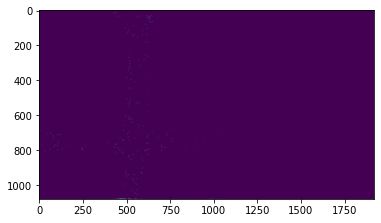

In [143]:
  plt.imshow(img)
  plt.imshow(density_map, alpha=1)
  plt.show()

In [145]:
np.sum(density_map)

188.64032